# 主流程文件 Main Training Script

> 主训练脚本入口，调用各模块进行模型训练
> 
> The main entry point for running training, orchestrating all modules for model training

## 简介/Description:
main 模块是项目的主训练入口。它结合了 core 模块中的任务定义和 data 模块中的数据加载功能，通过调用 PyTorch Lightning 的 Trainer 对模型进行训练。用户可以通过配置类快速切换不同的数据集、模型和训练策略，灵活完成实验任务。

The main module serves as the primary entry point for training. It combines task definitions from the core module and data loading from the data module to execute model training via PyTorch Lightning’s Trainer. Users can flexibly switch between different datasets, models, and training strategies through configuration classes to perform experiments.

## 主要符号/Main symbols:

- Trainer: PyTorch Lightning 的训练控制器，用于管理训练过程。  
  
  Trainer: The PyTorch Lightning controller for managing the training process.

- ClassificationTask: 从 core 导入，用于模型训练的主要任务类。
  
  ClassificationTask: Imported from core, the primary task class for model training.

- CIFAR100DataModule: 从 data 导入的数据加载模块。
  
  CIFAR100DataModule: Data loading module imported from data.

In [ ]:
#| default_exp __main__

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
from namable_classify.core import ClassificationTask, ClassificationTaskConfig
config = ClassificationTaskConfig()
# config.learning_rate = 1e-1
# config.learning_rate = 1
# config.learning_rate = 1e-3
# config.learning_rate = 1e-5
config.learning_rate = 3e-4
config.experiment_index = 1
# config.experiment_index = 0
# config.learning_rate = 1e-6
config.dataset_config.batch_size = 64
config.yuequ = "LORA"
cls_task = ClassificationTask(config)
cls_task.print_model_pretty()
import torch
# cls_task.cls_model = torch.compile(cls_task.cls_model, mode='reduce-overhead')
#  fullgraph=True

Seed set to 1
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


root
└── cls_model (HuggingfaceModel)
    ├── backbone (ViTModel)
    │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
    │   │   └── patch_embeddings (ViTPatchEmbeddings)
    │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
    │   ├── encoder (ViTEncoder)
    │   │   └── layer (ModuleList)
    │   │       └── 0-11(ViTLayer)
    │   │           ├── attention (ViTAttention)
    │   │           │   ├── attention (ViTSelfAttention)
    │   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
    │   │           │   └── output (ViTSelfOutput)
    │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]
    │   │           ├── intermediate (ViTIntermediate)
    │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
    │   │           ├── output (ViTOutput)
    │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]
    │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
    │   ├── layernorm (LayerNorm) weight:[768] bias:[768]
    │   └── pooler (ViTPooler)
    │       └── dense (Linear) weight:[768, 768] bias:[768]
    └── head (Linear) weight:[100, 768] bias:[100]

In [ ]:
#| export
from boguan_yuequ.auto import AutoYueQuAlgorithm
AutoYueQuAlgorithm(cls_task, config.yuequ)

Before 约取 (YueQu) , the model structure is: 


/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


root
└── cls_model (HuggingfaceModel)
    ├── backbone (ViTModel)
    │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
    │   │   └── patch_embeddings (ViTPatchEmbeddings)
    │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
    │   ├── encoder (ViTEncoder)
    │   │   └── layer (ModuleList)
    │   │       └── 0-11(ViTLayer)
    │   │           ├── attention (ViTAttention)
    │   │           │   ├── attention (ViTSelfAttention)
    │   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
    │   │           │   └── output (ViTSelfOutput)
    │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]
    │   │           ├── intermediate (ViTIntermediate)
    │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
    │   │           ├── output (ViTOutput)
    │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]
    │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
    │   ├── layernorm (LayerNorm) weight:[768] bias:[768]
    │   └── pooler (ViTPooler)
    │       └── dense (Linear) weight:[768, 768] bias:[768]
    └── head (Linear) weight:[100, 768] bias:[100]

Using LORA Algorithm from Hugging Face PEFT Library. 
peft_config: LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=False, r=8, target_modules=['query', 'value'], lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))
After 约取 (YueQu) , the model structure is: 


root
└── cls_model (HuggingfaceModel)
    ├── backbone (ViTModel)
    │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
    │   │   └── patch_embeddings (ViTPatchEmbeddings)
    │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
    │   ├── encoder (ViTEncoder)
    │   │   └── layer (ModuleList)
    │   │       └── 0-11(ViTLayer)
    │   │           ├── attention (ViTAttention)
    │   │           │   ├── attention (ViTSelfAttention)
    │   │           │   │   ├── query,value(Linear)
    │   │           │   │   │   ├── base_layer (Linear) weight:[768, 768] bias:[768]
    │   │           │   │   │   ├── lora_dropout (ModuleDict)
    │   │           │   │   │   ├── lora_A (ModuleDict)
    │   │           │   │   │   │   └── default (Linear) weight:[8, 768]
    │   │           │   │   │   └── lora_B (ModuleDict)
    │   │           │   │   │       └── default (Linear) weight:[768, 8]
    │   │           │   │   └── key (Linear) weight:[768, 768] bias:[768]
    │   │           │   └── output (ViTSelfOutput)
    │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]
    │   │           ├── intermediate (ViTIntermediate)
    │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
    │   │           ├── output (ViTOutput)
    │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]
    │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
    │   ├── layernorm (LayerNorm) weight:[768] bias:[768]
    │   └── pooler (ViTPooler)
    │       └── dense (Linear) weight:[768, 768] bias:[768]
    └── head (Linear) weight:[100, 768] bias:[100]

<boguan_yuequ.auto.AutoYueQuAlgorithm>

In [ ]:
# #| export
# import lightning as L
# trainer = L.Trainer()
# from lightning.pytorch.tuner import Tuner
# tuner = Tuner(trainer)
# found_batch_size = tuner.scale_batch_size(cls_task, datamodule=cls_task.lit_data, 
#                                         #   mode='binsearch', 
#                                           mode='power', 
#                                           init_val=64)
# # found_batch_size, cls_task.lit_data.hparams.batch_size
# print(f"Found batch size: {found_batch_size}")

In [ ]:
#| export
import lightning as L
from namable_classify.utils import runs_path
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary, StochasticWeightAveraging, DeviceStatsMonitor, LearningRateMonitor, LearningRateFinder
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger, WandbLogger

trainer = L.Trainer(default_root_dir=runs_path, enable_checkpointing=True, 
                    enable_model_summary=True, 
                    num_sanity_val_steps=2, # 防止 val 在训了好久train才发现崩溃
                    callbacks=[
                        # EarlyStopping(monitor="val_loss", mode="min")
                        EarlyStopping(monitor="val_acc1", mode="max", check_finite=True, 
                                      patience=5, 
                                    #   patience=6, 
                                      check_on_train_epoch_end=False,  # check on validation end
                                      verbose=True),
                        ModelSummary(max_depth=3),
                        # https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/
                        # StochasticWeightAveraging(swa_lrs=1e-2), 
                        # DeviceStatsMonitor(cpu_stats=True)
                        LearningRateMonitor(), 
                        # LearningRateFinder() # 有奇怪的bug
                               ]
                    , max_epochs=15
                    # , gradient_clip_val=1.0, gradient_clip_algorithm="value"
                    , logger=[
                        # TensorBoardLogger(save_dir=runs_path/"tensorboard"),
                        TensorBoardLogger(save_dir=runs_path),
                              CSVLogger(save_dir=runs_path), 
                              WandbLogger(project="namable_classify", name="test")
                              ]
                    # , profiler="simple"
                    # , fast_dev_run=True
                    # limit_train_batches=10, limit_val_batches=5
                    # strategy="ddp", accelerator="gpu", devices=4
                    )

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at /home/ycm/repos/research/cv/cls/NamableClassify/runs/.lr_find_ad3e3fcd-e3ae-4687-bfdc-bf8fe013adae.ckpt
Restored all states from the checkpoint at /home/ycm/repos/research/cv/cls/NamableClassify/runs/.lr_find_ad3e3fcd-e3ae-4687-bfdc-bf8fe013adae.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

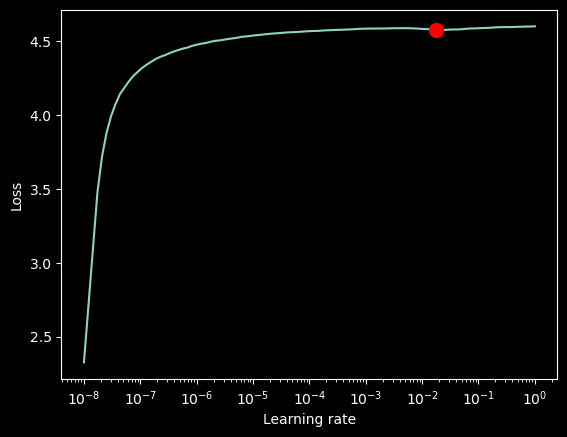

In [ ]:
#| export
#| eval: false
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(cls_task, datamodule=cls_task.lit_data, 
                        #   max_lr=1e-2
                        method = "fit",
                        min_lr = 1e-8,
                        # min_lr = 1e-4,
    max_lr = 1,
    # num_training = 10,
    num_training = 100,
    mode = "exponential"
    # mode = "linear"
                        
                          )
print(lr_finder.results)

fig = lr_finder.plot(suggest=True)
from matplotlib import pyplot as plt
from namable_classify.utils import runs_figs_path
plt.savefig(runs_figs_path/'lr_finder.png')
# fig.show()
new_lr = lr_finder.suggestion()
# new_lr, cls_task.hparams.learning_rate
print("New learning rate: ", new_lr)

cls_task.hparams.learning_rate = new_lr/10

In [ ]:
cls_task.hparams

"cls_model_config": {'provider': 'huggingface', 'checkpoint': 'google/vit-base-patch16-224-in21k', 'head_strategy': 'linear', 'num_of_classes': -1}
"dataset_config":   {'dataset_root': Path('/home/ycm/repos/research/cv/cls/NamableClassify/data'), 'dataset_name': 'CIFAR100', 'batch_size': 64}
"experiment_index": 1
"label_smoothing":  0.1
"learning_rate":    1e-08

In [ ]:
#| export
#| eval: false
trainer.fit(cls_task, datamodule=cls_task.lit_data)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                          | Type             | Params | Mode  | In sizes                                                                                     | Out sizes    
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | cls_model                     | HuggingfaceModel | 86.8 M | train | [1, 3, 224, 224]                                                                             | [1, 100]     
1 | cls_model.backbone            | ViTModel         | 86.7 M | train | [1, 3, 224, 224]                                                                             | ?            
2 | cls_model.backbone.embeddings | ViTEmbeddings    | 742 K  | train | [[1, 3, 224, 224], '?', '?']                                                                 | [1, 197, 768]
3 | cls_model.backbone.encoder  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
#| export
#| eval: false
trainer.test(cls_task, datamodule=cls_task.lit_data)

In [ ]:
#| eval: false
from namable_classify.utils import lib_repo_path
# trainer.test(cls_task, datamodule=cls_task.lit_data, 
trainer.validate(cls_task, datamodule=cls_task.lit_data, 
             ckpt_path=lib_repo_path/"deprecated/lightning_logs/version_53/checkpoints/epoch=11-step=8448.ckpt")

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Files already downloaded and verified
Files already downloaded and verified


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 2603119857 (handicraft-computing). Use `wandb login --relogin` to force relogin


Restoring states from the checkpoint path at /home/ycm/repos/research/cv/cls/NamableClassify/deprecated/lightning_logs/version_53/checkpoints/epoch=11-step=8448.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at /home/ycm/repos/research/cv/cls/NamableClassify/deprecated/lightning_logs/version_53/checkpoints/epoch=11-step=8448.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_acc1          │    0.8862000107765198     │
│         val_acc10         │    0.9904000163078308     │
│         val_acc2          │    0.9470000267028809     │
│         val_acc20         │    0.9950000047683716     │
│         val_acc3          │    0.9667999744415283     │
│         val_acc5          │    0.9819999933242798     │
│   val_balanced_accuracy   │    0.8862000107765198     │
│      val_cohen_kappa      │    0.8850504755973816     │
│          val_f1           │    0.8865798711776733     │
│      val_hinge_loss       │    0.3084784150123596     │
│       val_log_loss        │    0.5307707786560059     │
│         val_loss          │    1.1550344228744507     │
│   val_matthews_corrcoef   │    0.8851269483566284     │
│       val_precision       │    0.8938026428222656     │
│        val_recall         │    0.8862000107765198     │
│        val_roc_auc        │    0.9969171285629272     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.1550344228744507,
  'val_acc1': 0.8862000107765198,
  'val_acc2': 0.9470000267028809,
  'val_acc3': 0.9667999744415283,
  'val_acc5': 0.9819999933242798,
  'val_acc10': 0.9904000163078308,
  'val_acc20': 0.9950000047683716,
  'val_roc_auc': 0.9969171285629272,
  'val_matthews_corrcoef': 0.8851269483566284,
  'val_f1': 0.8865798711776733,
  'val_precision': 0.8938026428222656,
  'val_recall': 0.8862000107765198,
  'val_log_loss': 0.5307707786560059,
  'val_balanced_accuracy': 0.8862000107765198,
  'val_cohen_kappa': 0.8850504755973816,
  'val_hinge_loss': 0.3084784150123596}]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()